# Read me
This template is meant to be a starter for your customized DREEM output data analysis.

- To install this library, please check the installation on the [Git repo](https://github.com/yvesmartindestaillades/NAP).
- To learn how to use this library, please get through the [tutorial](tutorial.ipynb).


# Turner overthrown

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from os.path import exists, dirname
import os, sys
import numpy as np
import seaborn as sns
import json
from dreem_nap import data_wrangler, data_manip, database, plot, utils, wrapper
from dreem_nap.study import Study
from typing import Tuple, List

# Step 1: Data wrangling
### Step 1.1: Define your study and some basics about your project

In [2]:
# Set your root folder for the database (at the moment, keep Yves)
folder = 'multiplexed/v1/minbasecov1000'

path_to_data = '../data'

# Pull the firebase
# Firebase credentials file
firebase_credentials_file = f"{path_to_data}/credentials_firebase.json"
with open(firebase_credentials_file) as file:
    firebase_credentials = json.load(file)
database.connect(firebase_credentials)

# Select your study
study_name = 'all samples' 

## Set your base coverage high-pass filter value
min_bases_cov = 1000

# Set the resolution for the plots
mpl.rcParams['figure.dpi'] = 600 # the highest the resolution, the slowest the plotting
mpl.rcParams["figure.figsize"] = [25,7]
#plt.rcParams["figure.autolayout"] = True

# Depending on the study you select, you'll get a series of samples. You can also create new studies using this dictionary.
# Here's an example.

# Your studies under the shape of a dataframe
df_studies = data_wrangler.load_studies( f"{path_to_data}/samples.csv")
temp = df_studies.to_dict(orient='index')

# Your studies under the shape of a dictionary of Study
studies = {study: Study().from_dict(temp[study])  for study in temp}
print(f"Here are the available studies: {studies.keys()}")

# Load the study that you want
study = studies[study_name]

studies.pop('TO_DO_2')


Initiated connection to Firebase!
Here are the available studies: dict_keys(['180 mM DMS', '3.1 DMS', '3.2 DMS', '60 mM DMS', 'PEG1K', 'PEG3350', 'PEG8K', 'RNA titration', 'TO_DO_2', 'all samples', 'magnesium', 'replicates 1', 'replicates 2', 'salt', 'spermidine', 'spermine', 'temperature'])


### Step 1.2: Process new pickle files and push them to Firebase
- Select which samples you want to push to Firebase.
To plot automatically arrays of samples, see [tutorial](tutorial.ipynb), section 3.2.
- Process samples and push them to Firebase.

In [3]:
## Pickle files to process and to push to Firebase
pickles_list = []#study.samples # Can be samples if you want to process the samples from your study

pickles = {pickle:  f"{path_to_data}/MULTIPLEXED/{pickle}/mutation_histos.p" for pickle in pickles_list}

# Indicate the location of your RNA structure file
RNAstructureFile =  f"{path_to_data}/RNAstructureFileWithProb.csv"

# Default location for your local database (JSON file)
json_file_path =  f"{path_to_data}/saved_db/{folder}"

# If the user gives some new pickles files, push them to the firebase, then pull the entire firebase
if len(pickles):
    data_wrangler.push_samples_to_firebase(pickles = pickles,
                        RNAstructureFile = RNAstructureFile,
                        firebase_credentials = firebase_credentials,
                        min_bases_cov = min_bases_cov, 
                        folder=folder)

### Step 1.3: Pull the data from the Firebase and clean/reformat it.
`df` is used for the analysis. Each of the construct have above 1000 reads for each sample in at least one study.     
`df_full` is used for quality quality analysis. It has all construct above 1000 valid reads for each sample individually.

In [4]:
#df_database = database.load(study=study, folder=folder)
#utils.make_path(json_file_path)
#data_wrangler.json_dump(json_file=json_file_path+'/db.json', df=df_database)
df_database = data_wrangler.json_load(json_file_path+'/db.json')

Load from dict-type JSON file
Done!


In [5]:
# Clean and reformat the dataset
df, df_void, df_full = data_wrangler.filter_constructs_study_wise(df_database=df_database,
                                                studies=studies)

                                                
print(f"{df.groupby('construct')['samples_covered'].count().count()} constructs have more than {min_bases_cov} reads for each base of their ROI on each sample")

/Users/ymdt/src/dreem_nap/venv-nap/lib/python3.10/site-packages/dreem_nap/data_wrangler.py:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full['samples_covered'].loc[construct[1].index] = construct[1]['full_sequence'].count()
/Users/ymdt/src/dreem_nap/venv-nap/lib/python3.10/site-packages/dreem_nap/data_wrangler.py:203: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_loc = df_loc[df_loc.groupby('construct').count()['samp'] == len(studies[study].samples)]
/Users/ymdt/src/dreem_nap/venv-nap/lib/python3.10/site-packages/dreem_nap/data_wrangler.py:203: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_loc = df_loc[df_loc.groupby('construct').count()['samp'] == len(studies[study].samples)]
/Users/ymdt/src/dreem_nap/venv-nap/lib/python3.1

69 constructs were dropped because deltaG was 'void'
152 constructs have more than 1000 reads for each base of their ROI on each sample


# Step 2: Data quality analysis

It's always hard to realize that you were analysing noise. Here, we'll get through a series a plot to check the data sanity.

### Get the list of samples and constructs:

In [ ]:
print(f"samples are: {study.samples}")
print(f"constructs are: {df.construct.unique()}")


### How many constructs per sample?

In [ ]:
sns.histplot(df_database.groupby('samp').count()['construct'])
plt.ylabel('Count of samples')
plt.xlabel('# of valid constructs')

### Explore the data
`data_manip.get_roi_info()` gives information about the Region of Interest (ROI) of a (sample, construct) pair.

In [ ]:
samp, construct = data_manip.rand_sample_construct(df)
data_manip.get_roi_info(df=df,
                    samp=samp,
                    construct= construct,
                    bases_type= ['A', 'C', 'G','T'], #bases you want 
                    structure='both', # which structure prediction, 'full' or 'roi' 
                    overlay=0) # extend/shrink the roi, default is 0
                   # roi_range= list(range(-1, 110)))
                    #.xs((True, '0'),level=('paired','roi_structure_comparison'))    #additional filters

In [ ]:
construct = 8430
for samp in studies['180 mM DMS'].samples:
    wrapper.about_a_sample_construct(df, samp, construct, f"{path_to_data}/figs/date/about a construct/{construct}/{samp}")

### (sample, construct)-specific base coverage plot

In [ ]:
samp, construct = data_manip.rand_sample_construct(df)
plot.base_coverage(df, samp, construct)

### Plot the base coverage per construct distribution

In [ ]:
plot.base_coverage_ROI_for_all_constructs(df=df_full)

### Sanity-check construct-wise base coverage plots
Plot randomly picked sequences to check the quality of the data.

In [ ]:
plot.random_9_base_coverage(df=df)

### Heatmap of the roi part coverage

In [ ]:

def heatmap(df:pd.DataFrame, column:str)->None:
    """Plot the heatmap of a specific column of your dataframe, w.r.t the samples and constructs.

    Args:
        df: a Pandas dataframe.
        column: a specific column of your dataframe.    
    """

    base_cov_plot = df.pivot("samp","construct", column).astype(float)
    f, ax = plt.subplots()
    
    

    sns.heatmap(base_cov_plot, annot=False, linewidths=0, ax=ax, norm=LogNorm())


heatmap(df = df, 

             column="cov_bases_roi")

### Heatmap of the second half coverage

In [ ]:
plot.heatmap(df = df, 
                column="cov_bases_sec_half")

# Step 3: Data analysis
In this part, we know that we read good data, and we want to visualize it through different plots.

### Analysis parameters

Define a limited amount of constructs if that's useful to you

In [ ]:
# Display the plots on this notebook? Not recommended if numerous plots
show_plots = True

# Constructs used
a_few_constructs = df.construct.unique()[:3].tolist()
first_construct = df.construct.unique()[0].tolist()
constructs_per_name = {
    'all_construct': df.construct.unique().tolist(),
    str(a_few_constructs) : a_few_constructs,
    str(first_construct): [first_construct]
}

# Select constructs here
constructs_name = str(a_few_constructs)

# Define what you will analyse
constructs = constructs_per_name[constructs_name]

### Histogram of mutation (sample-construct)

`plot.mut_histogam(df, sample, construct, plot_type, index, normalize)` plots the mutation rate base-wise for a given construct of a given sample as a barplot. 
Arguments:
- `plot_type` :
    - `'sequence'` : each bar is colored w.r.t to the base of the original sequence.
    - `'partition'` : each bar shows the partition of into which bases this base mutates.
- `index`:
    - `'index'`: each base is identified with its position number
    - `'base'`: each base is identified with its type (A, C, G, T)

In [ ]:
constructs = constructs # Define this beforehand

for construct in constructs:
    for samp in study.samples:
        plot.mut_histogram(df=df,
                           samp=samp,
                           construct=construct,
                           plot_type='index') # Sequence (show the base and their index) or partition (show what the base mutates to)
        utils.save_fig(path=f"data/figs/date/{study.name}/mut_per_base/sequence/{construct}/", 
                    title=f"base_per_base_sequence_{samp}_{construct}")
        plt.close(not show_plots)

### DeltaG plots
For the entire sample

In [ ]:
for samp in study.samples:
    plot.deltaG(df=df, samp=samp)

    utils.save_fig(path=f"data/figs/date/{study}/deltaG/", 
             title=f"deltaG_{samp}")

    plt.close(not show_plots)

For specific bases

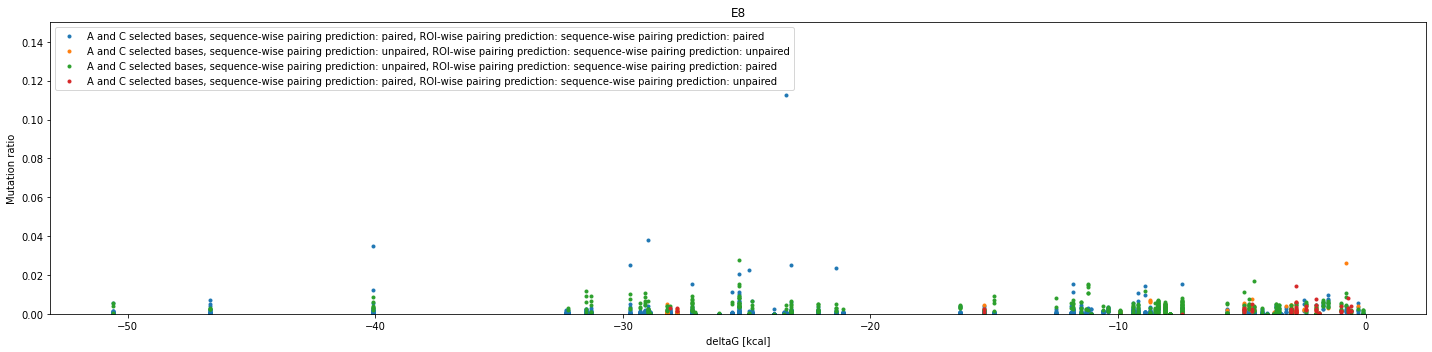

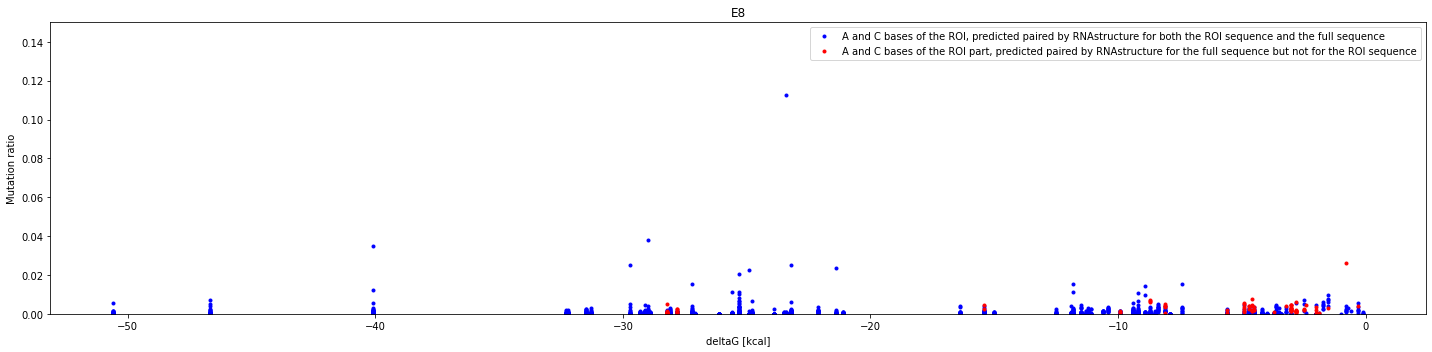

In [16]:


#deltaG_basewise(df, 'E8', [87, 90, 92, 93], 'MS2', 'unpaired')
#deltaG_basewise(df, 'E8', [87, 90, 92, 93], 'MS2', 'paired')

plot.deltaG_basewise(df, 'E8', list(range(0,150)))#, full_seq_pairing= 'paired')#, 'MS2')

plot.deltaG(df=df, samp='E8')




### Samples correlation
Only plot the correlation construct-by-construct

In [ ]:
for construct in [constructs[0]]:
        df_global_corr = plot.correlation_n_samples(df, study, [construct])
        plt.title(f"Study: {study.name}")
        utils.save_fig(path=f"data/figs/date/correlation/{study.name}", 
                      title=f"correlation_{study.name}_{construct}")
        plt.close(not show_plots)
        print(construct, end=' ')

### Heatmap of the R value + heatmap of the slope for the previous correlation dataset

In [ ]:
for plt_type in ['r_value', 'slope']:
    pivot = df_global_corr.pivot("sample_0","sample_1", plt_type).astype(float)
    f, ax = plt.subplots(figsize=(28, 10))
    sns.heatmap(pivot, annot=False, linewidths=0, ax=ax)#, norm=LinNorm())
    plt.title(plt_type)
    utils.save_fig(path=f"data/figs/date/global_correlation/{study.name}", 
                    title=f"correlation_{plt_type}_{study.name}_all_constructs")
    plt.close(not show_plots)

### Plot the correlation + heatmap of the R value + heatmap of the slope construct by construct

In [ ]:
show_plots = False
for _, study in studies:
    samples = study.samples
    for construct in df.construct.unique():
        construct_name = construct
        df_global_corr = plot.correlation_n_samples(df, study, construct)
        plt.title(f"Correlation between samples for study: {study.name}, constructs: {construct_name}")
        utils.save_fig(path=f"data/figs/date/correlation/{study.name}/{construct_name}", 
                        title=f"correlation_fit_{study.name}_{construct_name}")
        plt.close(not show_plots)

        for plt_type in ['r_value', 'slope']:
            pivot = df_global_corr.pivot("sample_0","sample_1", plt_type).astype(float)
            f, ax = plt.subplots(figsize=(28, 10))
            sns.heatmap(pivot, annot=False, linewidths=0, ax=ax)#, norm=LinNorm())
            plt.title(f"{plt_type} of the correlation between samples for study: {study.name}, construct: {construct_name}")
            utils.save_fig(path=f"data/figs/date/correlation/{study.name}/{construct_name}", 
                            title=f"correlation_{plt_type}_{study.name}_{construct_name}")
            plt.close(not show_plots)

### Plot the correlation + heatmap of the R value + heatmap of the slope for a bunch of constructs altogether

In [ ]:
heat_map = True

constructs = constructs # this has to be defined somewhere

for _, study in studies.iterrows():
    df_global_corr = plot.correlation_n_samples(df, study, constructs)
    utils.save_fig(path=f"data/figs/date/global_correlation/{study.name}", 
                    title=f"correlation_{study.name}_all_constructs")
    plt.close(not show_plots)

    if heat_map:
        for plt_type in ['r_value', 'slope']:
            pivot = df_global_corr.pivot("sample_0","sample_1", plt_type).astype(float)
            f, ax = plt.subplots(figsize=(28, 10))
            sns.heatmap(pivot, annot=False, linewidths=0, ax=ax, norm=LogNorm())
            utils.save_fig(path=f"data/figs/date/global_correlation/{study.name}", 
                            title=f"correlation_{plt_type}_{study.name}_all_constructs")
            plt.close(not show_plots)

### Temperature vs reactivity plots

In [ ]:
plot.study_sample(df, study, scale_x='log',structure='full', overlay=0, figsize=(16,8))
utils.save_fig(path=f"{path_to_data}/figs/date/study_behavior", 
            title=f"{study.name}.png")
#plt.close(not show_plots)

In [ ]:

for _, study in studies.iterrows():
    study =  Study().from_dict(study.to_dict())
    study.models = ['lambda x,a: np.log(x)+a']
    plot.study_sample(df, study, scale_x='log',structure='full', overlay=5, figsize=(16,8))
    utils.save_fig(path=f"{path_to_data}/figs/date/study_behavior", 
                title=f"{study.name}.png")
    plt.close()

### Base-wise mutation along a study

In [ ]:
for construct in [df.construct.unique()[0]]:
    for stu in studies:
        study = studies[stu]
        if study.name != 'temperature':
            continue
        plot.study_base(df=df,
                study=study,
                construct=9572, 
                scale_x='log', # can be log or lin
                bases_type=['A','C'],  # bsaes you want in A, C, G, T
                structure='full', # sequence for structure prediction. full or roi. 
                #overlay = 10,  # expand/shrink the roi. Can't expand roi if structure = 'roi'
                roi_range=list(range(40,120))) # select your favorite bases. Can't expand roi if structure = 'roi' 
                
        utils.save_fig(path= f"{path_to_data}/figs/date/Base-wise mutation along a study/{study.name}", 
                       title=f"{construct}_{study.name}.png")
      #  plt.close()

### Save columns to a csv file

In [ ]:
data_manip.columns_to_csv(df=df,
                   samples=samples,
                   columns=['sample', 'construct','full_sequence','roi_sequence','mut_bases','info_bases'],
                   title=f"seq_and_reactivity_{study}",
                   path='data/figs/date/{study}')

### Save construct vs deltaG 

In [ ]:
data_manip.deltaG_vs_construct_to_csv(df=df,    
                                 title=f"deltaG_vs_construct.csv", 
                                 path = f"data/figs/date/{study}", 
                                 samples=samples)